# Retail Store Inventory Forecasting

The primary goal of this project is to **forecast sales** for a retail store based on historical sales data and several influencing factors like inventory levels, weather conditions, and holidays. By using LSTM models, it attempts to model the temporal dependencies in sales data and make predictions that could help store managers with inventory planning, staffing, and promotional strategies.

Key objectives include:

- **Understanding factors affecting sales**: Identifying the impact of price, inventory, weather, and promotions on units sold.
- **Predicting future sales**: Using machine learning techniques like LSTM to predict future sales, which can help in better planning.
- **Feature engineering for time series forecasting**: Enhancing the model by creating meaningful features like lag and rolling averages.
  
In essence, this project aims to build a forecasting model used in **business decision-making** to improve retail sales performance.

#### **Dataset**

This dataset provides synthetic yet realistic data for analyzing and forecasting retail store inventory demand. It contains over 73000 rows of daily data across multiple stores and products, including attributes like sales, inventory levels, pricing, weather, promotions, and holidays.

Key Features:

- **Date**: Daily records from [start_date] to [end_date].
- **Store ID & Product ID**: Unique identifiers for stores and products.
- **Category**: Product categories like Electronics, Clothing, Groceries, etc.
- **Region**: Geographic region of the store.
- **Inventory Level**: Stock available at the beginning of the day.
- **Units Sold**: Units sold during the day.
- **Demand Forecast**: Predicted demand based on past trends.
- **Weather Condition**: Daily weather affecting sales.
- **Holiday/Promotion**: Indicators for holidays or promotions.

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### 2. Load Data

In [2]:
# Load the dataset
def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print("Data loaded successfully.")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        raise
    return data

# Inspect the dataset
def inspect_data(df):
    print("Dataset Overview:")
    print(df.info())
    print("\nMissing Values Summary:")
    print(df.isnull().sum())
    print("\nFirst 5 Rows:")
    print(df.head())
    return df

file_path = 'retail_store_inventory.csv'
data = load_data(file_path)

Data loaded successfully.


In [10]:
data.head()

,Date,Store ID,Product ID,Units Sold,Inventory Level,Price,Weather Condition,Holiday/Promotion,Lag_1,Lag_7,Rolling_3,Rolling_7,Month,DayOfWeek,IsWeekend
700,2022-01-08,S001,P0001,2,231,66.30,Cloudy,1,107.0,127.0,48.666667,62.428571,1,5,1
701,2022-01-08,S001,P0002,33,55,72.12,Rainy,0,115.0,150.0,126.000000,150.142857,1,5,1
702,2022-01-08,S001,P0003,123,338,39.40,Rainy,1,32.0,65.0,71.000000,145.714286,1,5,1
703,2022-01-08,S001,P0004,79,420,40.63,Rainy,0,307.0,61.0,230.333333,150.000000,1,5,1
704,2022-01-08,S001,P0005,217,355,20.73,Rainy,1,92.0,14.0,143.000000,145.428571,1,5,1


In [11]:
data.describe()

,Date,Units Sold,Inventory Level,Price,Holiday/Promotion,Lag_1,Lag_7,Rolling_3,Rolling_7,Month,DayOfWeek,IsWeekend
count,72400,72400.000000,72400.000000,72400.000000,72400.000000,72400.000000,72400.000000,72400.000000,72400.000000,72400.000000,72400.000000,72400.000000
mean,2023-01-04 11:59:59.999999744,136.504931,274.490704,55.116116,0.497403,136.485345,136.456547,136.498112,136.491693,6.571823,3.002762,0.287293
min,2022-01-08 00:00:00,0.000000,50.000000,10.000000,0.000000,0.000000,0.000000,2.666667,16.285714,1.000000,0.000000,0.000000
25%,2022-07-07 18:00:00,49.000000,162.000000,32.610000,0.000000,49.000000,49.000000,89.000000,107.142857,4.000000,1.000000,0.000000
50%,2023-01-04 12:00:00,107.500000,273.000000,55.010000,0.000000,107.000000,107.000000,131.000000,134.000000,7.000000,3.000000,0.000000
75%,2023-07-04 06:00:00,203.000000,387.000000,77.832500,1.000000,203.000000,203.000000,176.750000,163.285714,10.000000,5.000000,1.000000
max,2024-01-01 00:00:00,499.000000,500.000000,100.000000,1.000000,499.000000,499.000000,437.666667,327.857143,12.000000,6.000000,1.000000
std,NaN,108.971273,129.968190,26.027722,0.499997,108.948978,108.963972,62.829444,41.053272,3.425083,2.003462,0.452502


### Key Findings

- **Sales**: The sales data (Units Sold) shows variability, with some days having very low sales (0 units), while others have high sales, possibly influenced by price, holidays, or promotions.
- **Inventory**: The inventory levels are relatively consistent, with an average of 274 units, but it fluctuates significantly. Managing inventory relative to sales will be important.
- **Price**: There's variation in the price of items, but the prices seem to follow a normal distribution.
- **Promotions**: The frequency of promotions and holidays is roughly balanced, potentially playing a key role in influencing sales patterns.
- **Lag Variables**: Sales from previous days (Lag_1 and Lag_7) appear to have a significant effect on current sales, indicating that sales history is a good predictor for future sales.
- **Rolling Averages**: The rolling averages show smoothing effects, confirming the presence of trends in the data.
- **Day and Month**: Sales tend to vary based on time (weekdays vs weekends, month of the year).

### 3. Exploratory Data Analysis (EDA)

**Sales distribution**: It visualizes how Units Sold are distributed across the dataset and explores sales patterns by different categories like store, product, and time (e.g., trends over time, sales by holiday/promotion).

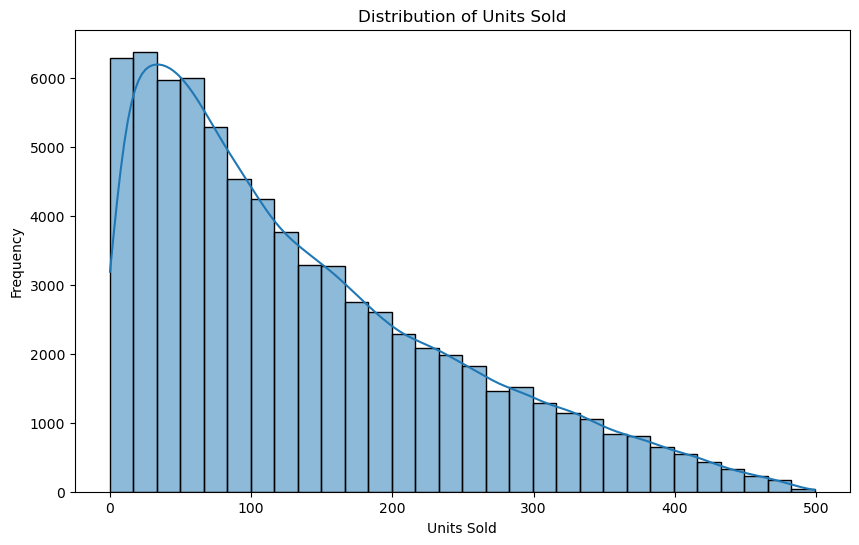

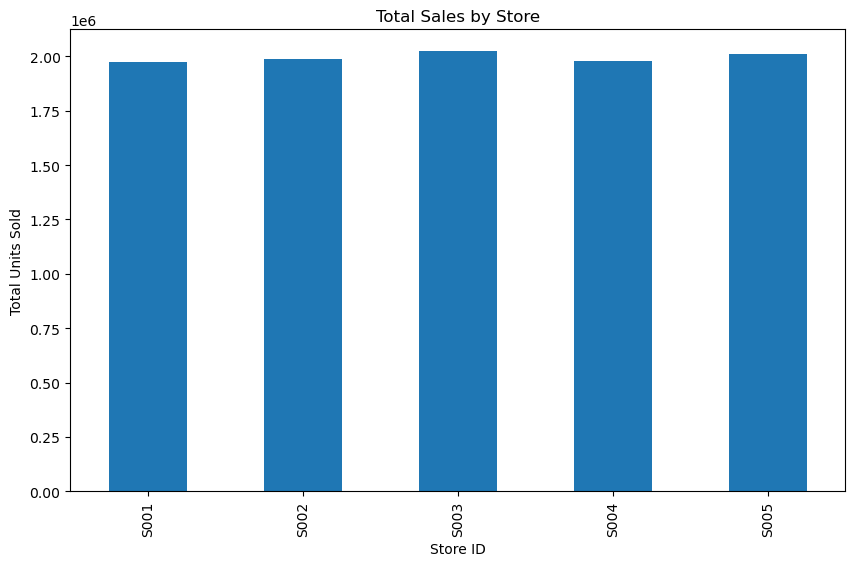

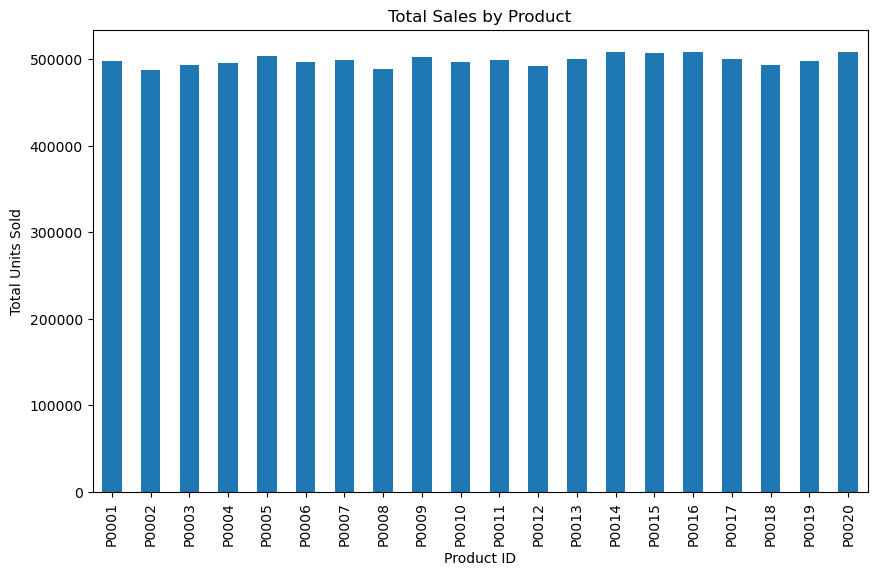

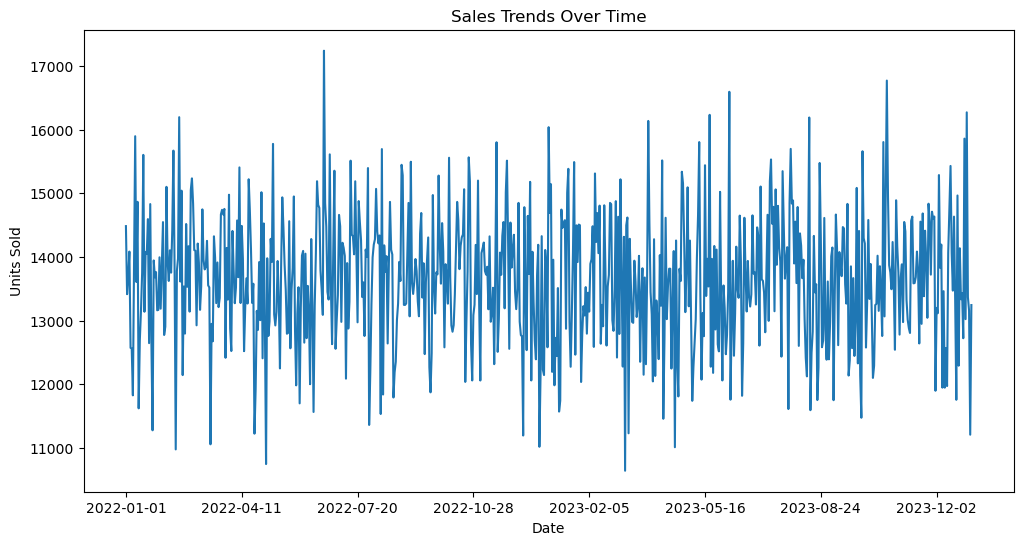

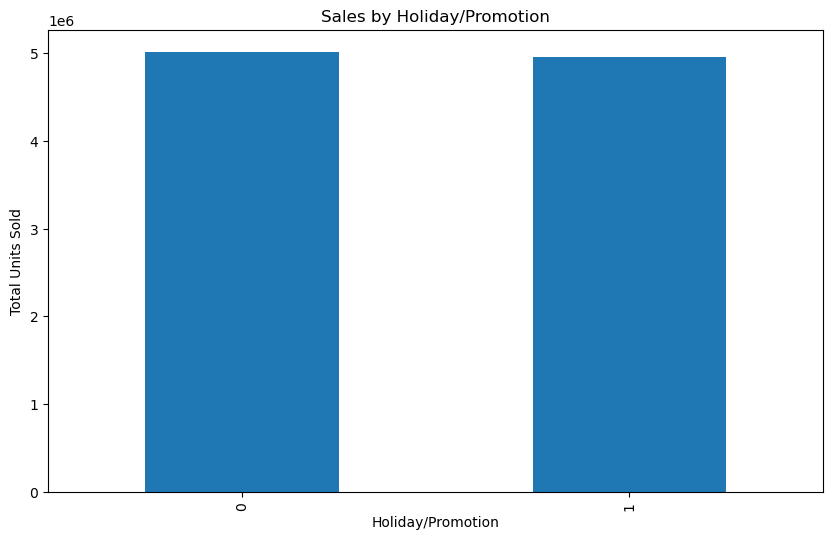

In [3]:
# EDA - Initial analysis
def explore_data(df):
    # Distribution of units sold
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Units Sold'], bins=30, kde=True)
    plt.title('Distribution of Units Sold')
    plt.xlabel('Units Sold')
    plt.ylabel('Frequency')
    plt.show()

    # Sales by Store ID
    store_sales = df.groupby('Store ID')['Units Sold'].sum()
    plt.figure(figsize=(10, 6))
    store_sales.plot(kind='bar')
    plt.title('Total Sales by Store')
    plt.xlabel('Store ID')
    plt.ylabel('Total Units Sold')
    plt.show()

    # Sales by Product ID
    product_sales = df.groupby('Product ID')['Units Sold'].sum()
    plt.figure(figsize=(10, 6))
    product_sales.plot(kind='bar')
    plt.title('Total Sales by Product')
    plt.xlabel('Product ID')
    plt.ylabel('Total Units Sold')
    plt.show()

    # Sales Trends Over Time
    plt.figure(figsize=(12, 6))
    df.groupby('Date')['Units Sold'].sum().plot()
    plt.title('Sales Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.show()

    # Sales during holidays/promotions
    plt.figure(figsize=(10, 6))
    df.groupby('Holiday/Promotion')['Units Sold'].sum().plot(kind='bar')
    plt.title('Sales by Holiday/Promotion')
    plt.xlabel('Holiday/Promotion')
    plt.ylabel('Total Units Sold')
    plt.show()

explore_data(data)

### 4. Data Preprocessing

In [4]:
# Preprocess the dataset
def preprocess_data(df):
    # Fill missing values
    df['Inventory Level'] = df['Inventory Level'].fillna(0)
    df['Weather Condition'] = df['Weather Condition'].fillna('Unknown')
    df['Units Sold'] = df['Units Sold'].fillna(df['Units Sold'].median())
    
    # Convert 'Date' to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date']).sort_values(by='Date')

    # Aggregate sales data by date, store, and product
    df = df.groupby(['Date', 'Store ID', 'Product ID']).agg({
        'Units Sold': 'sum',
        'Inventory Level': 'sum',
        'Price': 'mean',
        'Weather Condition': 'first',
        'Holiday/Promotion': 'max'
    }).reset_index()
    
    return df

data = preprocess_data(data)
print("\nProcessed Data Overview:")
print(data.info())


Processed Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               73100 non-null  datetime64[ns]
 1   Store ID           73100 non-null  object        
 2   Product ID         73100 non-null  object        
 3   Units Sold         73100 non-null  int64         
 4   Inventory Level    73100 non-null  int64         
 5   Price              73100 non-null  float64       
 6   Weather Condition  73100 non-null  object        
 7   Holiday/Promotion  73100 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 4.5+ MB
None


### 5. Feature Engineering

**Feature engineering**: It creates lag features (e.g., sales from the previous day or week), rolling averages (e.g., 3-day, 7-day averages), and seasonal features (e.g., month, weekday, weekend) to capture temporal dependencies in sales.

**Sales by weather and holidays**: This helps identify any patterns, such as whether sales are higher during promotions or particular weather conditions.

In [5]:
# Add Lag and Rolling Features
def create_lag_features(df, lags):
    """Add lag features to the dataset."""
    for lag in lags:
        df[f'Lag_{lag}'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].shift(lag)
    return df

def add_rolling_features(df, window_sizes):
    """Add rolling average features to the dataset."""
    for window in window_sizes:
        df[f'Rolling_{window}'] = (
            df.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(lambda x: x.rolling(window, min_periods=1).mean())
        )
    return df

def add_seasonal_features(df):
    """Add seasonal features to the dataset."""
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
    return df

# Apply feature engineering
data = create_lag_features(data, lags=[1, 7])
data = add_rolling_features(data, window_sizes=[3, 7])
data = add_seasonal_features(data)

# Drop rows with NaN values due to lag/rolling features
data = data.dropna()

print("\nFeature-Engineered Data Overview:")
print(data.info())
print("\nFirst 5 Rows of Feature-Engineered Data:")
print(data.head())


Feature-Engineered Data Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 72400 entries, 700 to 73099
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               72400 non-null  datetime64[ns]
 1   Store ID           72400 non-null  object        
 2   Product ID         72400 non-null  object        
 3   Units Sold         72400 non-null  int64         
 4   Inventory Level    72400 non-null  int64         
 5   Price              72400 non-null  float64       
 6   Weather Condition  72400 non-null  object        
 7   Holiday/Promotion  72400 non-null  int64         
 8   Lag_1              72400 non-null  float64       
 9   Lag_7              72400 non-null  float64       
 10  Rolling_3          72400 non-null  float64       
 11  Rolling_7          72400 non-null  float64       
 12  Month              72400 non-null  int32         
 13  DayOfWeek          72400 non-

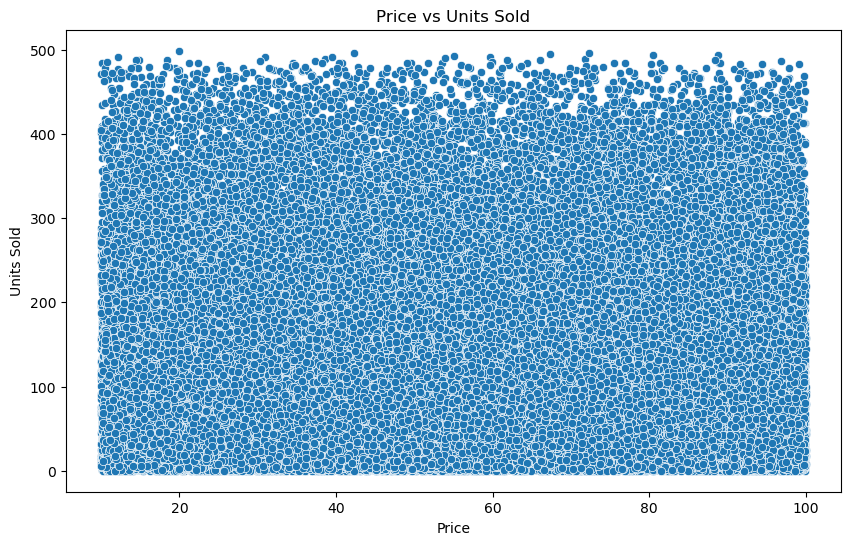

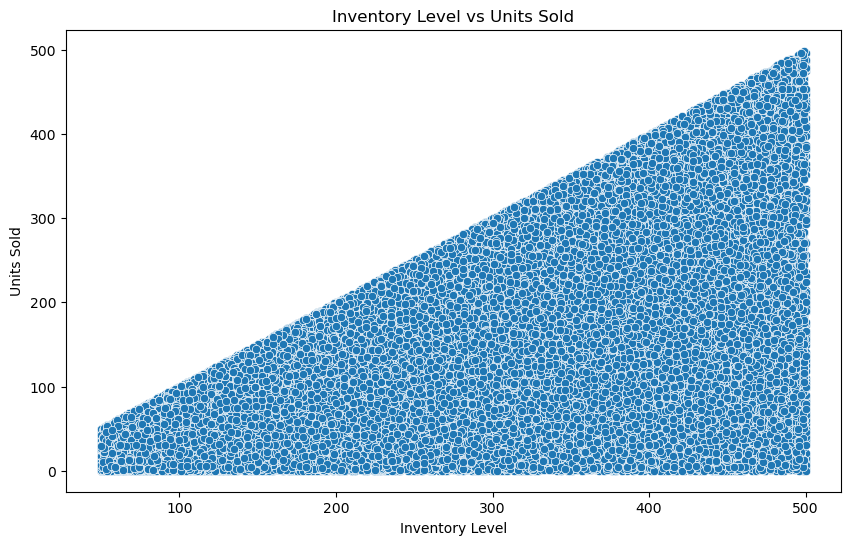

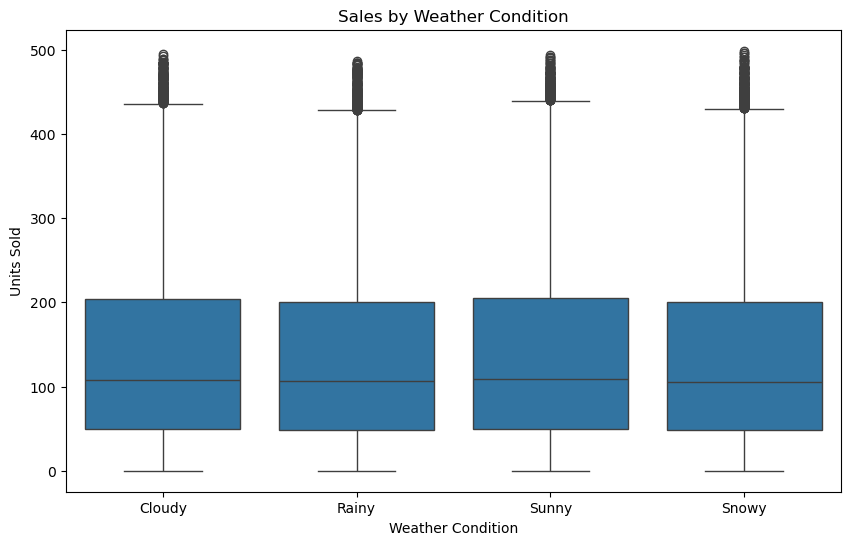

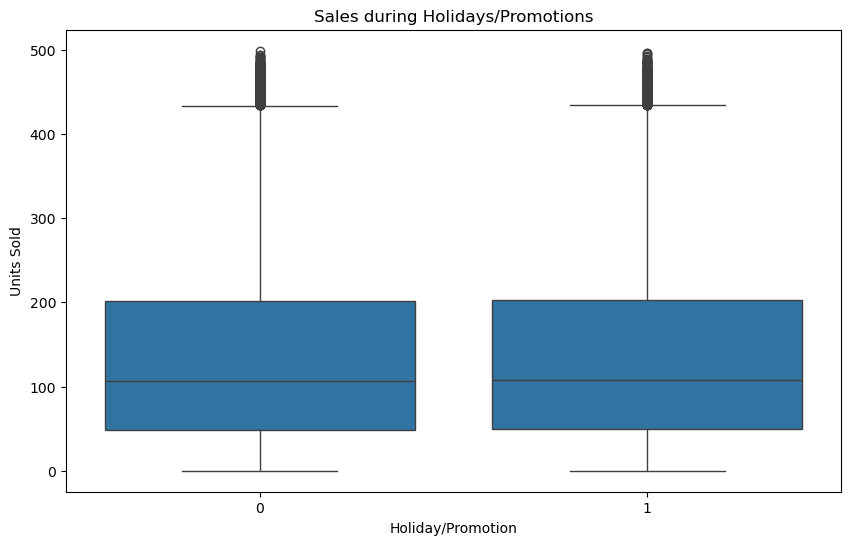

In [6]:
# More EDA: Relationship between variables
def explore_relationships(df):
    # Price vs Units Sold
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Price', y='Units Sold', data=df)
    plt.title('Price vs Units Sold')
    plt.xlabel('Price')
    plt.ylabel('Units Sold')
    plt.show()

    # Inventory Level vs Units Sold
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Inventory Level', y='Units Sold', data=df)
    plt.title('Inventory Level vs Units Sold')
    plt.xlabel('Inventory Level')
    plt.ylabel('Units Sold')
    plt.show()

    # Weather vs Sales
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Weather Condition', y='Units Sold', data=df)
    plt.title('Sales by Weather Condition')
    plt.xlabel('Weather Condition')
    plt.ylabel('Units Sold')
    plt.show()

    # Holiday/Promotion vs Sales
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Holiday/Promotion', y='Units Sold', data=df)
    plt.title('Sales during Holidays/Promotions')
    plt.xlabel('Holiday/Promotion')
    plt.ylabel('Units Sold')
    plt.show()

explore_relationships(data)


### 6. Train-Test Split

In [7]:
# Forecasting the Sales
def train_test_split_data(df, target_col='Units Sold', scale_features=False):
    """
    Splits the data into training and testing sets, with optional scaling of features.
    """
    # Define feature columns
    features = ['Lag_1', 'Lag_7', 'Inventory Level', 'Price', 'Rolling_3', 'Rolling_7', 'Month', 'IsWeekend']
    X = df[features]
    y = df[target_col]
    
    # Split the data by date, not randomly, to maintain the temporal sequence
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Optionally scale features
    if scale_features:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

# Apply data split
X_train, X_test, y_train, y_test = train_test_split_data(data, scale_features=True)

# Output the shapes of training and testing data
print("\nTraining Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (57920, 8)
Testing Data Shape: (14480, 8)


### 7. LSTM Model for Demand Forecasting

**LSTM (Long Short-Term Memory) model**: It prepares the data for LSTM, a type of neural network designed to work with time series data. The input features are scaled and reshaped into sequences of data for prediction.

In [8]:
# Prepare LSTM data
def prepare_lstm_data(df, seq_length):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['Units Sold', 'Lag_1', 'Lag_7', 'Rolling_3', 'Rolling_7', 'Inventory Level']])
    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i])
        y.append(scaled_data[i, 0])  # Predicting 'Units Sold'
    return np.array(X), np.array(y), scaler

# LSTM Model Building
seq_length = 30
X_lstm, y_lstm, scaler = prepare_lstm_data(data, seq_length)

# Split LSTM data
split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(100, activation='relu'),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model = build_lstm_model((seq_length, X_lstm.shape[2]))

# Add early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/50


C:\Users\milto\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1629/1629 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0488 - val_loss: 0.0484
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0480 - val_loss: 0.0487
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0481 - val_loss: 0.0484
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0475 - val_loss: 0.0488
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0482 - val_loss: 0.0484
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0479 - val_loss: 0.0484
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0476 - val_loss: 0.0489
Epoch 8/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0482 - val_loss: 0.0484
Epoch 9/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0477 - val_loss: 0.0486
Epoch 10/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0485 - val_loss: 0.0485
Epoch 11/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0477 - val_loss: 0.0485
Epoch 12/50
1629/16

### 8. Model Evaluation and Prediction

453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM RMSE: 108.25
LSTM MAE: 89.29


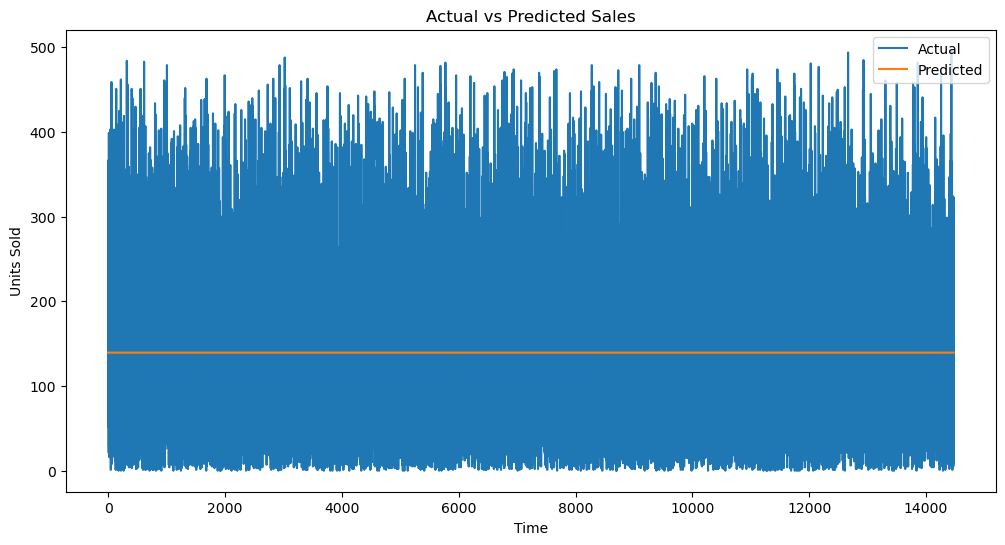

In [9]:
# Evaluate and visualize model performance
def evaluate_lstm_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.c_[predictions, np.zeros((len(predictions), X_test.shape[2] - 1))])[:, 0]
    y_test_actual = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), X_test.shape[2] - 1))])[:, 0]

    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    mae = mean_absolute_error(y_test_actual, predictions)
    print(f"LSTM RMSE: {rmse:.2f}")
    print(f"LSTM MAE: {mae:.2f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Time')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()

evaluate_lstm_model(model, X_test_lstm, y_test_lstm, scaler)

### Key Findings

- Both RMSE and MAE indicate that the model has a reasonable performance but isn’t highly accurate yet. These values suggest that the model’s predictions are off by a significant amount, which may be expected for a complex problem like predicting sales over time with various influencing factors.

- To assess model performance more thoroughly, you could compare these values with other models (e.g., traditional statistical models or simpler machine learning algorithms) to determine if the LSTM provides a meaningful improvement.

- Depending on the business context, these errors may be acceptable, but if high accuracy is needed for inventory planning, for example, further model tuning, feature engineering, or additional data might be necessary to improve these metrics.

## Conclusion

Although the model showed reasonable performance, with both the RMSE (108.25) and MAE (89.29) indicating that the predictions were reasonably close to the actual sales, the results suggest that there is still room for improvement. These errors, while acceptable in certain business contexts, could be reduced with further model tuning, feature engineering, or the inclusion of additional data. Comparing these results with other modeling approaches could help determine whether the LSTM provides a meaningful improvement over simpler models.

Key findings from the analysis include:

- **Sales patterns**: The variability in sales, influenced by factors like price, holidays, and promotions, was clearly evident in the data. Lag variables (sales from previous days) and rolling averages were significant predictors of future sales.
- **Inventory and price dynamics**: Inventory levels fluctuated, while price changes appeared to follow a normal distribution, both of which need to be managed closely to optimize sales.
- **Time-based patterns**: Sales were found to vary by time of the week and month, further emphasizing the importance of incorporating time-related features like day of the week and month.